In [477]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import wasserstein_distance
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

import lime
import lime.lime_tabular

from tqdm import tqdm
from joblib import Parallel, delayed
import time

In [478]:
model_config = {
    XGBClassifier: {
        "n_estimators": 100,
        "max_depth": 5,
        "learning_rate": 0.1,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "gamma": 0.1,
        "reg_lambda": 1,
        "reg_alpha": 0,
        "scale_pos_weight": 1,
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
    },
    RandomForestClassifier: {
        "n_estimators": 100,
        "max_depth": 3,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "max_leaf_nodes": None,
        "min_impurity_decrease": 0,
        "bootstrap": True,
        "oob_score": False,
        "n_jobs": -1,
        "random_state": 42,
        "verbose": 0,
        "warm_start": False,
        "class_weight": None,
    },
    GradientBoostingClassifier: {
        "loss": "log_loss",
        "learning_rate": 0.1,
        "n_estimators": 100,
        "subsample": 1.0,
        "criterion": "friedman_mse",
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "min_weight_fraction_leaf": 0.0,
        "max_depth": 3,
        "min_impurity_decrease": 0.0,
        "init": None,
        "random_state": 42,
        "verbose": 0,
        "max_leaf_nodes": None,
        "warm_start": False,
        "validation_fraction": 0.1,
        "n_iter_no_change": None,
        "tol": 0.0001,
        "ccp_alpha": 0.0,
    },
    AdaBoostClassifier: {
        "base_estimator": None,
        "n_estimators": 50,
        "learning_rate": 1.0,
        "algorithm": "SAMME.R",
        "random_state": 42,
    },
    LogisticRegression: {
        "penalty": "l2",
        "dual": False,
        "tol": 0.0001,
        "C": 1.0,
        "fit_intercept": True,
        "intercept_scaling": 1,
        "class_weight": None,
        "random_state": 42,
        "solver": "lbfgs",
        "max_iter": 100,
        "multi_class": "auto",
        "verbose": 0,
        "warm_start": False,
        "n_jobs": -1,
        "l1_ratio": None,
    },
}

In [479]:
def global_feat_importance(clf, train):
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
        features    = train.columns
        feat_importances = pd.DataFrame()
        feat_importances["weight"] = importances
        feat_importances.index = features
        main = feat_importances.to_dict()['weight']
        return {key:round(value,2) for (key,value) in main.items()}

def explain_preds(df, sample_size, model, explainer) -> dict:

    def process(row):
        exp = explainer.explain_instance(df.iloc[row], model.predict_proba, num_features=len(df.columns))
        return exp.as_list()[0]

    random_sample  = Parallel(n_jobs=-1)(delayed(process)(row) for row in range(df.sample(frac=sample_size).shape[0]))

    explained_dict = pd.DataFrame(random_sample).iloc[:, 0].value_counts(normalize = True).to_dict()

    return {key:round(value, 2) for (key, value) in explained_dict.items()}

def distance(df, target_column_name):

    feature_distance = {}

    for feature in df.columns:
        if feature != target_column_name:
            target_feature  = df[df[target_column_name] == 1][feature]
            control_feature = df[df[target_column_name] == 0][feature]
            feature_distance[feature] = round(wasserstein_distance(target_feature, control_feature), 1)

    return feature_distance



start_time = time.time()

def train_evaluate_models(model_config, data, target_column_name, verbose = False):

    feature_distance = distance(data, target_column_name)

    class_balance = data[target_column_name].value_counts(normalize = True).to_dict()

    class_balance = {key:round(value, 2) for (key, value) in class_balance.items()}

    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = target_column_name), data[target_column_name], test_size=0.2, random_state=42)

    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data = np.array(X_train),
        feature_names = X_train.columns,
        class_names   = [1, 0],
        mode          = 'classification'
    )

    results = {}

    if verbose:
        sequence = tqdm(model_config.keys())
    else:
        sequence = model_config.keys()


    for model in sequence:

        start_time = time.time()

        # fit model
        candidate = model(**model_config[model])
        candidate.fit(X_train.values, y_train.values)

        # make predictions for test data
        y_pred = candidate.predict(X_test.values)

        # evaluate predictions
        accuracy  = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall    = recall_score(y_test, y_pred)
        auc       = roc_auc_score(y_test, y_pred)

        # feature attribution
        global_importance = global_feat_importance(candidate, X_train)
        local_importance  = explain_preds(df=X_test, sample_size=0.4, model=candidate, explainer=explainer)

        # save results
        results[model.__name__] = {
            'accuracy': round(accuracy, 2),
            'precision': round(precision, 2),
            'recall': round(recall, 2),
            'roc_auc': round(auc, 2),
            'class_balance': class_balance,
            'feature_distance':  feature_distance,
            'global_importance': global_importance,
            'local_importance':  local_importance,
            'training_time': f'{round(time.time() - start_time, 2)}s',
            'artifact': candidate
            }

        if verbose:
            print(f"--- Training time for {model.__name__}: {round((time.time() - start_time)/60,1)} minutes ---")

    return results

In [480]:
N = 10_000

features = {
    'feature_1': np.random.normal(0, 1, N),
    'feature_2': np.random.normal(10, 1, N),
    }

target = pd.DataFrame(features)
target['label'] = 1

control = pd.DataFrame(features)
control['label'] = 0

df = pd.concat([target, control])
df.head()


,feature_1,feature_2,label
0,-0.670904,10.137083,1
1,-0.502265,9.933123,1
2,-0.143398,11.227671,1
3,0.025301,7.068201,1
4,0.379864,9.617595,1


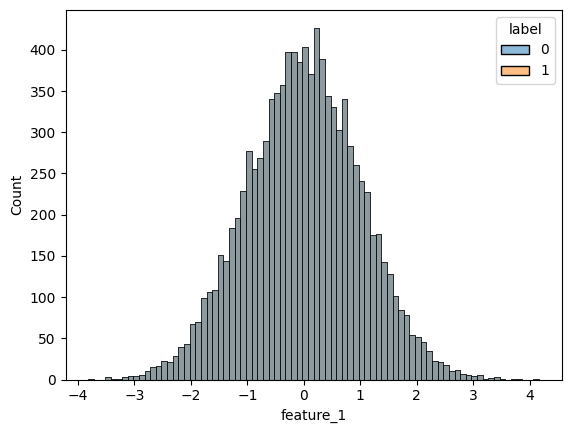

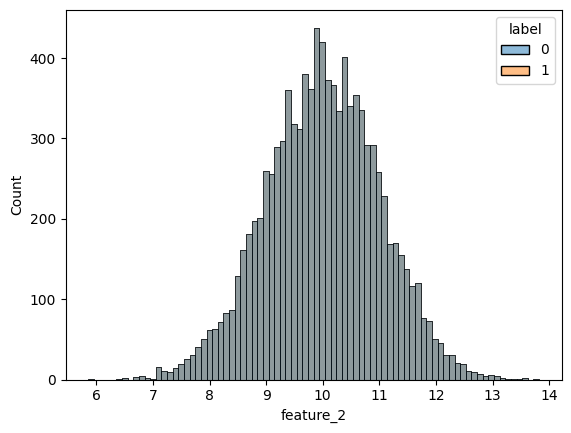

In [481]:
for i, col in enumerate(df.columns):
    if col != 'label':
        plt.figure(i)
        sns.histplot(df, x=col, hue='label',)

In [482]:
no_signal = train_evaluate_models(model_config=model_config, data=df, target_column_name='label')

pd.DataFrame(no_signal).T

,accuracy,precision,recall,roc_auc,feature_distance,global_importance,local_importance,training_time,artifact
XGBClassifier,0.31,0.32,0.32,0.31,"{'feature_1': 0.0, 'feature_2': 0.0}","{'feature_1': 0.5, 'feature_2': 0.5}","{'-0.01 < feature_1 <= 0.68': 0.26, '-0.69 < f...",10.95s,"XGBClassifier(base_score=0.5, booster='gbtree'..."
RandomForestClassifier,0.44,0.43,0.35,0.44,"{'feature_1': 0.0, 'feature_2': 0.0}","{'feature_1': 0.5, 'feature_2': 0.5}","{'feature_1 > 0.68': 0.25, '-0.69 < feature_1 ...",32.38s,"(DecisionTreeClassifier(max_depth=3, max_featu..."
GradientBoostingClassifier,0.4,0.39,0.35,0.4,"{'feature_1': 0.0, 'feature_2': 0.0}","{'feature_1': 0.51, 'feature_2': 0.49}","{'-0.69 < feature_1 <= -0.01': 0.25, '-0.01 < ...",6.97s,([DecisionTreeRegressor(criterion='friedman_ms...
AdaBoostClassifier,0.44,0.44,0.35,0.44,"{'feature_1': 0.0, 'feature_2': 0.0}","{'feature_1': 0.38, 'feature_2': 0.62}","{'-0.69 < feature_1 <= -0.01': 0.25, '-0.01 < ...",10.81s,"(DecisionTreeClassifier(max_depth=1, random_st..."
LogisticRegression,0.49,0.49,0.32,0.49,"{'feature_1': 0.0, 'feature_2': 0.0}",None,"{'feature_1 > 0.68': 0.26, 'feature_1 <= -0.69...",3.78s,"LogisticRegression(n_jobs=-1, random_state=42)"


In [483]:
# Vertical shift of the distribution

df['feature_1'] = np.where(df['label'] == 0, df['feature_1'] * 3, df['feature_1'])

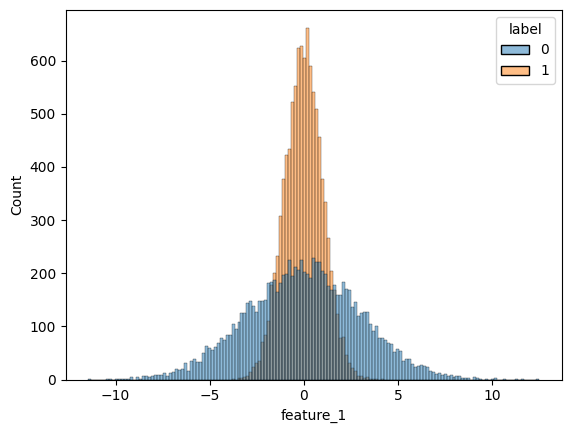

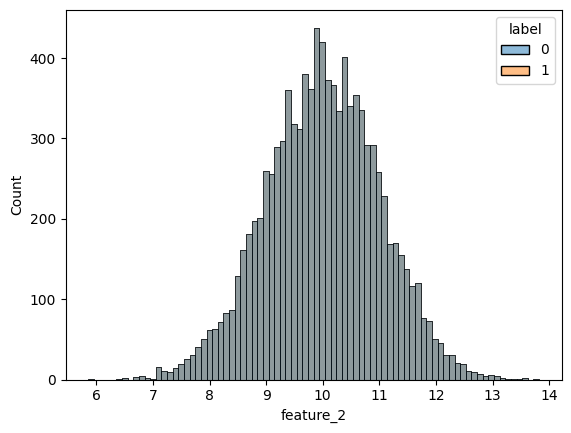

In [484]:
for i, col in enumerate(df.columns):
    if col != 'label':
        plt.figure(i)
        sns.histplot(df, x=col, hue='label',)

In [485]:
# Vertical shifts have some predictive power

some_signal = train_evaluate_models(model_config=model_config, data=df, target_column_name='label')

pd.DataFrame(some_signal).T

,accuracy,precision,recall,roc_auc,feature_distance,global_importance,local_importance,training_time,artifact
XGBClassifier,0.74,0.69,0.89,0.74,"{'feature_1': 1.6, 'feature_2': 0.0}","{'feature_1': 0.96, 'feature_2': 0.04}","{'-0.01 < feature_1 <= 1.07': 0.26, 'feature_1...",5.38s,"XGBClassifier(base_score=0.5, booster='gbtree'..."
RandomForestClassifier,0.73,0.67,0.95,0.73,"{'feature_1': 1.6, 'feature_2': 0.0}","{'feature_1': 0.96, 'feature_2': 0.04}","{'-0.01 < feature_1 <= 1.07': 0.26, 'feature_1...",30.21s,"(DecisionTreeClassifier(max_depth=3, max_featu..."
GradientBoostingClassifier,0.74,0.69,0.89,0.74,"{'feature_1': 1.6, 'feature_2': 0.0}","{'feature_1': 0.98, 'feature_2': 0.02}","{'-0.01 < feature_1 <= 1.07': 0.26, 'feature_1...",6.9s,([DecisionTreeRegressor(criterion='friedman_ms...
AdaBoostClassifier,0.74,0.67,0.94,0.74,"{'feature_1': 1.6, 'feature_2': 0.0}","{'feature_1': 0.94, 'feature_2': 0.06}","{'-0.01 < feature_1 <= 1.07': 0.26, 'feature_1...",10.86s,"(DecisionTreeClassifier(max_depth=1, random_st..."
LogisticRegression,0.5,0.5,0.21,0.5,"{'feature_1': 1.6, 'feature_2': 0.0}",None,"{'feature_2 > 10.68': 0.27, '10.00 < feature_2...",2.7s,"LogisticRegression(n_jobs=-1, random_state=42)"


In [486]:
# Horizontal shift of the distribution

df['feature_2'] = np.where(df['label'] == 0, df['feature_2'] + 3, df['feature_2'])

# Reset vertical shift (optional)

df['feature_1'] = np.where(df['label'] == 0, df['feature_1'] / 3, df['feature_1'])

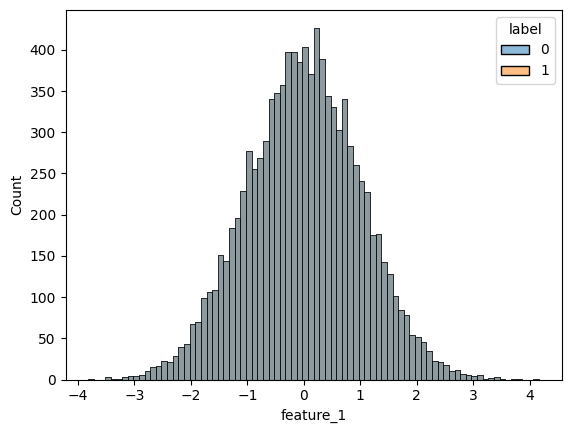

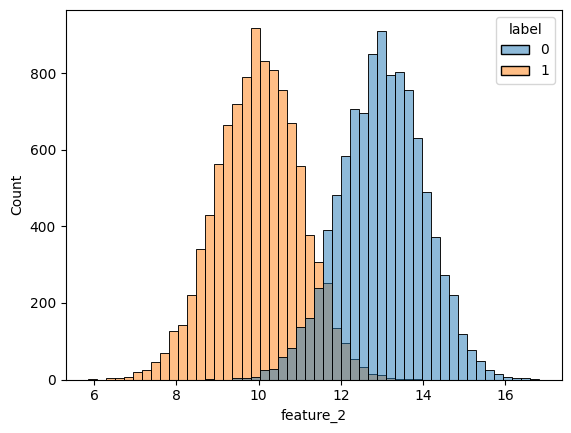

In [487]:
for i, col in enumerate(df.columns):
    if col != 'label':
        plt.figure(i)
        sns.histplot(df, x=col, hue='label',)

In [488]:
# Horizontal shifts are much more important than vertical shifts

high_signal = train_evaluate_models(model_config=model_config, data=df, target_column_name='label')

pd.DataFrame(high_signal).T

,accuracy,precision,recall,roc_auc,feature_distance,global_importance,local_importance,training_time,artifact
XGBClassifier,0.93,0.93,0.93,0.93,"{'feature_1': 0.0, 'feature_2': 3.0}","{'feature_1': 0.02, 'feature_2': 0.98}","{'feature_2 > 13.00': 0.27, 'feature_2 <= 10.0...",5.41s,"XGBClassifier(base_score=0.5, booster='gbtree'..."
RandomForestClassifier,0.93,0.93,0.93,0.93,"{'feature_1': 0.0, 'feature_2': 3.0}","{'feature_1': 0.05, 'feature_2': 0.95}","{'feature_2 > 13.00': 0.27, 'feature_2 <= 10.0...",32.18s,"(DecisionTreeClassifier(max_depth=3, max_featu..."
GradientBoostingClassifier,0.92,0.92,0.93,0.92,"{'feature_1': 0.0, 'feature_2': 3.0}","{'feature_1': 0.0, 'feature_2': 1.0}","{'feature_2 > 13.00': 0.27, 'feature_2 <= 10.0...",7.12s,([DecisionTreeRegressor(criterion='friedman_ms...
AdaBoostClassifier,0.93,0.92,0.93,0.93,"{'feature_1': 0.0, 'feature_2': 3.0}","{'feature_1': 0.1, 'feature_2': 0.9}","{'feature_2 > 13.00': 0.27, 'feature_2 <= 10.0...",11.08s,"(DecisionTreeClassifier(max_depth=1, random_st..."
LogisticRegression,0.93,0.93,0.92,0.93,"{'feature_1': 0.0, 'feature_2': 3.0}",None,"{'feature_2 > 13.00': 0.27, 'feature_2 <= 10.0...",2.75s,"LogisticRegression(n_jobs=-1, random_state=42)"
